### Introduction:

#### This project attempts to identify latent structures in text data and visualize them. The dataset used consists of top 100 films of all times according to an imdb list [(Top 100 Greatest Movies of All Time (The Ultimate List) by ChrisWalczyk55)](http://www.imdb.com/list/ls055592025/)



Contents:
    - Importing required libraries and data 
    - Stemming and Tokenization of Synopses
    - TF-IDF and documnet similarity
    - 

#### Importing required libraries

In [3]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.manifold import MDS
import mpld3
import nltk
import psycopg2
import nltk
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import gensim


#### Importing titles, imdb and wikipedia synopses and imdb links:

In [4]:
os.chdir("/home/pjoshi/github/data-science/projects/document-clustering")

# Titles:
titles = open('title_list.txt').read().split('\n')
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

# Synopses: (strip html code and convert to unicode)

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki
    
    
synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb


genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' wiki synopses')
print(str(len(synopses_imdb)) + ' imdb synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 wiki synopses
100 imdb synopses
100 genres


#### Combining imdb and wiki synopses:

In [5]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

#### Generating an index for each item in corpora


In [6]:
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

## Stemming and Tokenization of Synopses



#### Import stopwords, snowball stemmer 
#### [Snowball stemmer](http://snowball.tartarus.org/) is a part of NLTK.  

In [7]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords[1:10])

# Import Snowball stemmer

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

[u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your']


#### Define functions to tokenize and stem:


In [8]:
def tokenize_and_stem(text):
    # tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]',token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # tokenizes the synopsis only
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

#### Iterate over synopses to create 2 vocabularies, one stemed and one only tokenized


In [9]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

#### Using these two lists, create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column which can be used to to look up a stem and return a full token. 


In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame.head(10)


----

## TF-IDF and Document Similarity

* We first attempt to find groups of similar synopses using TF-IDF

* Term Frequency - Inverse Document Frequency is a statistic intended to reflect how important a word is to a document in a collection or corpus.[1]

* Word occurences by documet are calulated and converted into a document-term matrix that gives the frequency of occurence of each term in each document.

* Parameters used in the TF-IDF Vectoriser are:

##### 1. max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
##### 2. min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document.
##### 3. ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See n-grams


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 9.89 s, sys: 61.1 ms, total: 9.95 s
Wall time: 9.92 s
(100, 563)


In [13]:
terms = tfidf_vectorizer.get_feature_names()
from sklearn import preprocessing, metrics, model_selection


dist is defined as 1 - cosine similarity of each document and used as a measure of similarity between each synopsis and all other synopses. Subtracting it from 1 provides cosine distance which will be used for plotting on a 2D plane.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)


To better understand the hidden structure within the synopses, we cluster them using the tf-idf matrix. For clustering, 3 algorithms are attempted: 

1. K-Means clustering is attempted first with 5 clusters.
2. Hierarchical Clustering using Ward Algorithm
3. Latent Dirchlet Allocation

### 1. K- Means Clustering

In [15]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters = num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()


CPU times: user 536 ms, sys: 176 µs, total: 536 ms
Wall time: 535 ms


Using joblib.dump() to pickle the model, once it has converged and reload the model/reassign labels as clusters.

In [16]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

Creating a dictionary of titles, ranks, the synopsis, the cluster assignment, and the genre and converting to a Pandas DataFrame:

In [17]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [18]:
# check number of films per cluster
frame['cluster'].value_counts()

0    49
3    21
4    17
1     7
2     6
Name: cluster, dtype: int64

In [19]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()


cluster
0    50.448980
1    72.714286
2    52.833333
3    44.428571
4    42.294118
Name: rank, dtype: float64

Indexing and sorting on each cluster to identify which are the top n words that are nearest to the cluster centroid to give a good sense of the main topic of the cluster.

In [ ]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.iloc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

In [22]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [23]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rank</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>18</td>
      <td>The Sound of Music</td>
    </tr>
    <tr>
      <td>50</td>
      <td>Jaws</td>
    </tr>
    <tr>
      <td>84</td>
      <td>Nashville</td>
    </tr>
    <tr>
      <td>88</td>
      <td>The African Queen</td>
    </tr>
    <tr>
      <td>90</td>
      <td>Mutiny on the Bounty</td>
    </tr>
    <tr>
      <td>92</td>
      <td>A Clockwork Orange</td>
    </tr>
    <tr>
      <td>94</td>
      <td>Wuthering Heights</td>
    </tr>
  </tbody>
</table>


## Multidimensional Scaling:

Using MDS we convert the DTM into a 2D array for visualizing the clusters

In [24]:
MDS()

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

## Visualizing document clusters

In [25]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

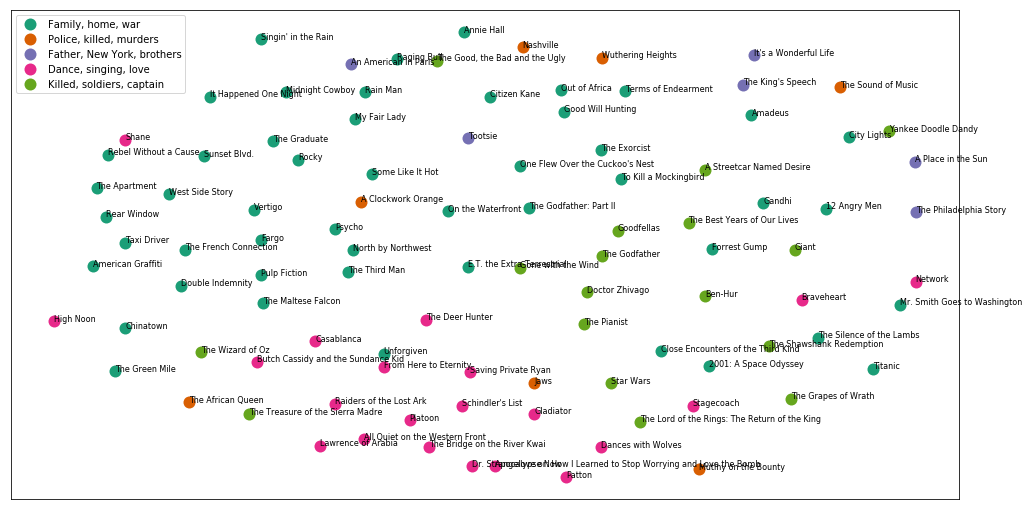

In [26]:
%matplotlib inline


#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom='off',       # ticks along the bottom edge are off
        top='off',          # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot


#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [27]:
plt.close()


----

### 2. Hierarchical document clustering

Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. 

The precomputed cosine distance matrix (dist) is used to calclate a linkage_matrix, which I then plot as a dendrogram.

This method returned 3 primary clusters, with the largest cluster being split into about 4 major subclusters. 

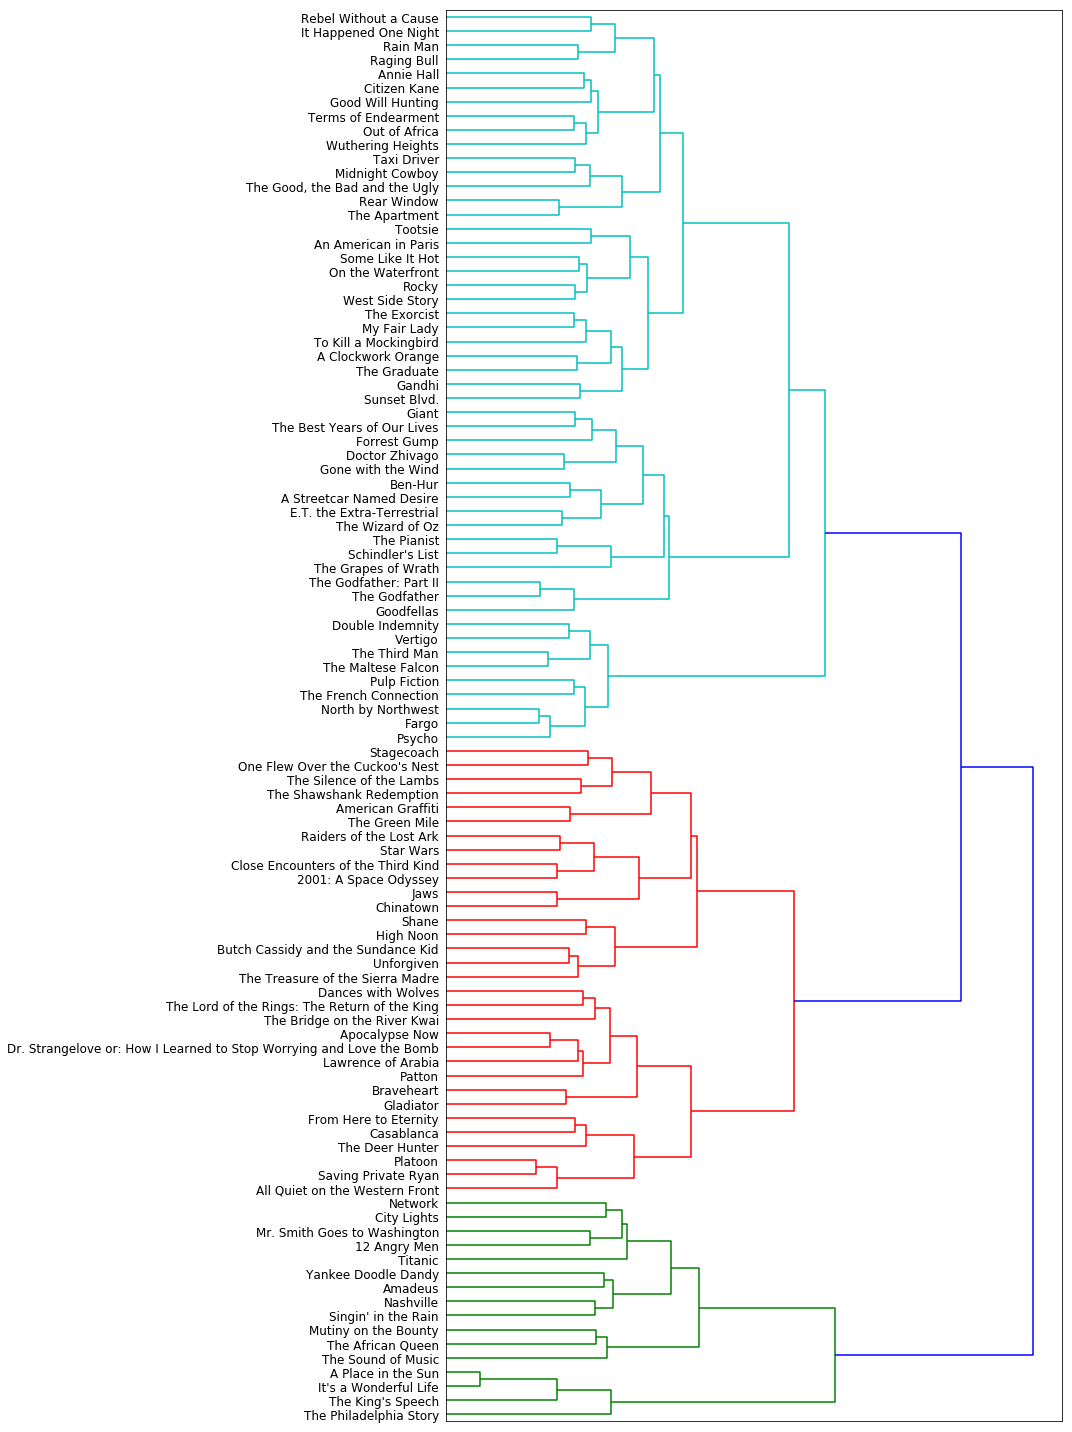

In [67]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize = (15,20)) #set size
x = dendrogram(linkage_matrix, orientation = "right", labels = titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tick_params(axis='y', which='major', labelsize=12) # adjust text size of labels on y axis

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters



In [29]:
plt.close()

----

### 3. Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. 


In [30]:
# function to removing any proper names from a text
import string
import gensim
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

# removing stop words, proper nouns and tokenization
from gensim import corpora, models, similarities 

# remove proper names
%time preprocess = [strip_proppers(doc) for doc in synopses]

# tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

# remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]


CPU times: user 4.56 s, sys: 14.3 ms, total: 4.57 s
Wall time: 4.55 s
CPU times: user 4.47 s, sys: 3.75 ms, total: 4.47 s
Wall time: 4.47 s
CPU times: user 557 ms, sys: 64 ms, total: 620 ms
Wall time: 527 ms


In [31]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
len(corpus)

%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

print(lda[corpus[0]])

topics = lda.print_topics(5, num_words=20)

topics_matrix = lda.show_topics(formatted=False, num_words=20)


In [ ]:
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]

for i in len(topic_words):
    print([str(word) for word in i])
    print()

In [87]:
 topics_matrix[1:5]

[(1,
  [(u'famili', 0.0066484674),
   (u'kill', 0.0060548508),
   (u'prison', 0.0058451593),
   (u'ask', 0.0045528426),
   (u'offic', 0.0043224767),
   (u'meet', 0.0039651459),
   (u'brother', 0.0038569674),
   (u'men', 0.003818538),
   (u'order', 0.0036844956),
   (u'father', 0.0035587128),
   (u'later', 0.003411375),
   (u'help', 0.0033269941),
   (u'two', 0.0032888185),
   (u'friend', 0.0030755578),
   (u'attempt', 0.0028620535),
   (u'year', 0.0028548795),
   (u'also', 0.0028229703),
   (u'escap', 0.0028003075),
   (u'arriv', 0.0026970832),
   (u'night', 0.0026706595)]),
 (2,
  [(u'famili', 0.0057632742),
   (u'home', 0.0056718267),
   (u'love', 0.0055420659),
   (u'friend', 0.0046223765),
   (u'film', 0.0045869588),
   (u'father', 0.0041883839),
   (u'marri', 0.0040809293),
   (u'life', 0.0039329594),
   (u'work', 0.0038920923),
   (u'say', 0.0037784122),
   (u'run', 0.0036085462),
   (u'want', 0.0034430514),
   (u'way', 0.0034125296),
   (u"n't", 0.0033922214),
   (u'come', 0.003

----

## Clustering using Word Vectors

- We can also use pre-trained worrd embeddings in the forms of Word vectors for the clustering task.
- Here, I have used Google's pretrained Word2Vec model which includes word vectors for a vocabulary of 3 million words and phrases that Google trained on roughly 100 billion words from a Google News dataset. The vector length is 300 features.

In [35]:
model = gensim.models.KeyedVectors.load_word2vec_format('/home/pjoshi/github/data-science/projects/document-clustering/GoogleNews-vectors-negative300.bin', binary=True)  

In [33]:
synopses_df = pd.DataFrame.merge(pd.DataFrame(titles), pd.DataFrame(synopses),left_index = True, right_index = True)

In [36]:
synopses_df.iloc[0, 1].split()

[u'Plot',
 u'[edit]',
 u'[',
 u'[',
 u'edit',
 u'edit',
 u']',
 u']',
 u'On',
 u'the',
 u'day',
 u'of',
 u'his',
 u'only',
 u"daughter's",
 u'wedding,',
 u'Vito',
 u'Corleone',
 u'hears',
 u'requests',
 u'in',
 u'his',
 u'role',
 u'as',
 u'the',
 u'Godfather,',
 u'the',
 u'Don',
 u'of',
 u'a',
 u'New',
 u'York',
 u'crime',
 u'family.',
 u"Vito's",
 u'youngest',
 u'son,',
 u'Michael,',
 u'in',
 u'a',
 u'Marine',
 u'Corps',
 u'uniform,',
 u'introduces',
 u'his',
 u'girlfriend,',
 u'Kay',
 u'Adams,',
 u'to',
 u'his',
 u'family',
 u'at',
 u'the',
 u'sprawling',
 u'reception.',
 u"Vito's",
 u'godson',
 u'Johnny',
 u'Fontane,',
 u'a',
 u'popular',
 u'singer,',
 u'pleads',
 u'for',
 u'help',
 u'in',
 u'securing',
 u'a',
 u'coveted',
 u'movie',
 u'role,',
 u'so',
 u'Vito',
 u'dispatches',
 u'his',
 u'consigliere,',
 u'Tom',
 u'Hagen,',
 u'to',
 u'Los',
 u'Angeles',
 u'to',
 u'influence',
 u'the',
 u'abrasive',
 u'studio',
 u'head,',
 u'Jack',
 u'Woltz.',
 u'Woltz',
 u'is',
 u'unmoved',
 u'unti

- We ignore stopwords in the synopses and aggregate word vectors for other words in each synposes:

In [37]:
from nltk.corpus import stopwords

sentence_vectors = np.empty((300,))
filtered_sentence = []
stop_words = set(stopwords.words('english'))

sum_vector = np.zeros(model.vector_size)
for i in range(0, len(synopses_df)):
    sentences = synopses_df.iloc[i, 1]
    sentence_tokens = tokenize_and_stem(sentences) 
    for token in sentence_tokens:
        if token not in stop_words and token in model:
            sum_vector += model[token]
        sentence_vector = sum_vector / len(sentence_tokens)
    sentence_vectors = np.vstack((sentence_vectors, sentence_vector))
sentence_vectors = np.delete(sentence_vectors, 0, 0)
sentence_vectors = pd.DataFrame(sentence_vectors)

In [70]:
sentence_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.000662,0.020068,0.007824,0.025592,-0.013629,0.000743,0.000990,-0.035616,0.031966,0.028599,...,-0.004853,0.021612,-0.028425,0.009870,-0.027565,-0.016752,-0.019451,-0.031745,-0.006617,0.014366
1,0.004353,0.034595,0.018915,0.061042,-0.026258,0.001745,0.012041,-0.064447,0.066126,0.069631,...,-0.018175,0.050300,-0.068302,0.020820,-0.044753,-0.037660,-0.038470,-0.068159,0.001629,0.025998
2,0.015965,0.072990,0.039797,0.117422,-0.062290,0.013376,0.031752,-0.123113,0.121882,0.122339,...,-0.043723,0.097212,-0.148771,0.039408,-0.081984,-0.070637,-0.078742,-0.120959,0.005487,0.048424
3,0.020576,0.083884,0.040448,0.132124,-0.071011,0.016609,0.035812,-0.147394,0.145720,0.154963,...,-0.041867,0.108931,-0.178261,0.043698,-0.105724,-0.093590,-0.092183,-0.153703,-0.004825,0.068159
4,0.024684,0.116232,0.057077,0.186954,-0.107175,0.020826,0.045610,-0.207968,0.197406,0.207702,...,-0.042141,0.151387,-0.235651,0.054334,-0.142047,-0.124582,-0.135018,-0.202489,-0.008151,0.094426


- Combining the movie titles and correspinding vectors:

In [71]:
title_sentence_vectors = pd.DataFrame.merge(pd.DataFrame(titles), pd.DataFrame(sentence_vectors),left_index = True, right_index = True)
title_sentence_vectors.rename(columns={'0_x': 'Title','0_y':'0'}, inplace=True)
title_sentence_vectors.head()

,Title,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,The Godfather,-0.000662,0.020068,0.007824,0.025592,-0.013629,0.000743,0.000990,-0.035616,0.031966,...,-0.004853,0.021612,-0.028425,0.009870,-0.027565,-0.016752,-0.019451,-0.031745,-0.006617,0.014366
1,The Shawshank Redemption,0.004353,0.034595,0.018915,0.061042,-0.026258,0.001745,0.012041,-0.064447,0.066126,...,-0.018175,0.050300,-0.068302,0.020820,-0.044753,-0.037660,-0.038470,-0.068159,0.001629,0.025998
2,Schindler's List,0.015965,0.072990,0.039797,0.117422,-0.062290,0.013376,0.031752,-0.123113,0.121882,...,-0.043723,0.097212,-0.148771,0.039408,-0.081984,-0.070637,-0.078742,-0.120959,0.005487,0.048424
3,Raging Bull,0.020576,0.083884,0.040448,0.132124,-0.071011,0.016609,0.035812,-0.147394,0.145720,...,-0.041867,0.108931,-0.178261,0.043698,-0.105724,-0.093590,-0.092183,-0.153703,-0.004825,0.068159
4,Casablanca,0.024684,0.116232,0.057077,0.186954,-0.107175,0.020826,0.045610,-0.207968,0.197406,...,-0.042141,0.151387,-0.235651,0.054334,-0.142047,-0.124582,-0.135018,-0.202489,-0.008151,0.094426


- The symantic similarity between the movie synopses can now be visualised by clustering the movies based on their word vectors.


In [73]:
# We standardize the dataset to have 0 mean and unit standard deviation prior to inputting to the K-Means algorithm.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(sentence_vectors))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [74]:
sentence_vectors_normalised = scaler.transform(sentence_vectors)

- Using K means, we cluster the dataset into 5 clusters

In [75]:
km = sklearn.cluster.KMeans(n_clusters=5)
km.fit(sentence_vectors_normalised)
clusters = km.labels_.tolist()  # Get cluster assignment labels

In [76]:
synopses_clusters_df = pd.DataFrame.merge(pd.DataFrame(titles),pd.DataFrame(sentence_vectors_normalised),left_index = True, right_index = True)
synopses_clusters_df = pd.DataFrame.merge(pd.DataFrame(synopses_clusters_df), pd.DataFrame(clusters),left_index = True, right_index = True)


synopses_clusters_df.columns.values[301] = 'cluster'   
synopses_clusters_df.columns.values[0] = 'title'
synopses_clusters_df.columns.values[1] = '0'


- Viewing the resulting clusters:

In [78]:
synopses_clusters_df.head() 

,title,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,cluster
0,The Godfather,-0.976609,-0.999152,-1.217755,-0.970735,0.991222,-1.530536,-1.005456,0.982811,-0.991677,...,-0.966914,0.998914,-0.946601,0.991232,0.987192,1.019994,1.002237,-0.886865,-1.084030,2
1,The Shawshank Redemption,-0.964646,-0.986813,-1.155439,-0.953746,0.980580,-1.518050,-0.987851,0.969691,-0.974834,...,-0.947408,0.981429,-0.924403,0.977075,0.972299,1.000616,0.981402,-0.823355,-1.064720,2
2,Schindler's List,-0.936944,-0.954198,-1.038110,-0.926727,0.950212,-1.373121,-0.956450,0.942995,-0.947341,...,-0.915510,0.946144,-0.886722,0.946410,0.948811,0.959583,0.951192,-0.793643,-1.027492,2
3,Raging Bull,-0.925944,-0.944944,-1.034454,-0.919681,0.942862,-1.332834,-0.949983,0.931946,-0.935587,...,-0.907542,0.933212,-0.878024,0.926857,0.932463,0.945889,0.932457,-0.873063,-0.994730,2
4,Casablanca,-0.916144,-0.917466,-0.941018,-0.893404,0.912384,-1.280282,-0.934374,0.904382,-0.910101,...,-0.878674,0.908048,-0.856462,0.896940,0.910388,0.902245,0.904543,-0.898677,-0.951125,2


In [79]:
list(synopses_clusters_df['title'].groupby(synopses_clusters_df['cluster']))


[(0, 31                        Apocalypse Now
  32                                Gandhi
  40              A Streetcar Named Desire
  42                 To Kill a Mockingbird
  43                  An American in Paris
  44           The Best Years of Our Lives
  45                          My Fair Lady
  46                               Ben-Hur
  48                                Patton
  50                            Braveheart
  51        The Good, the Bad and the Ugly
  52    Butch Cassidy and the Sundance Kid
  54                         The Apartment
  55                               Platoon
  57                    Dances with Wolves
  58                           The Pianist
  59                            Goodfellas
  60                          The Exorcist
  61                       The Deer Hunter
  62        All Quiet on the Western Front
  63                 The French Connection
  65                     The King's Speech
  67                    A Place in the Sun
  73    

----

#### References:
[1] https://en.wikipedia.org/wiki/Tf%E2%80%93idf

----

<div style="text-align: right"> End of Document </div>
